>> Loading CSVs ...
train/val/test shapes: (108087, 49) (69993, 49) (83035, 49)
after drop_zero_rows: (108087, 49) (69993, 49) (83035, 49)
>> Using 35 features.
Example features: ['Returns', 'Vol_5d', 'Vol_10d', 'Vol_20d', 'Vol_30d', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_200', 'Price_to_SMA_20']

>> Training FAST baseline XGB ...

=== VAL (FAST) ===
{'split': 'val (FAST)', 'roc_auc': 0.5655062767548485, 'balanced_acc': 0.5420781087019881}
              precision    recall  f1-score   support

           0      0.551     0.601     0.575     35972
           1      0.534     0.483     0.507     34021

    accuracy                          0.544     69993
   macro avg      0.543     0.542     0.541     69993
weighted avg      0.543     0.544     0.542     69993

Confusion matrix:
 [[21626 14346]
 [17590 16431]]
Best VAL AUC (tiny grid): 0.565033 {'max_depth': 4, 'subsample': 0.7}

>> Train FINAL XGB with best tiny-grid params ...

=== VAL ===
{'split': 'val', 'roc_auc': 0.5647637204005442, 'b

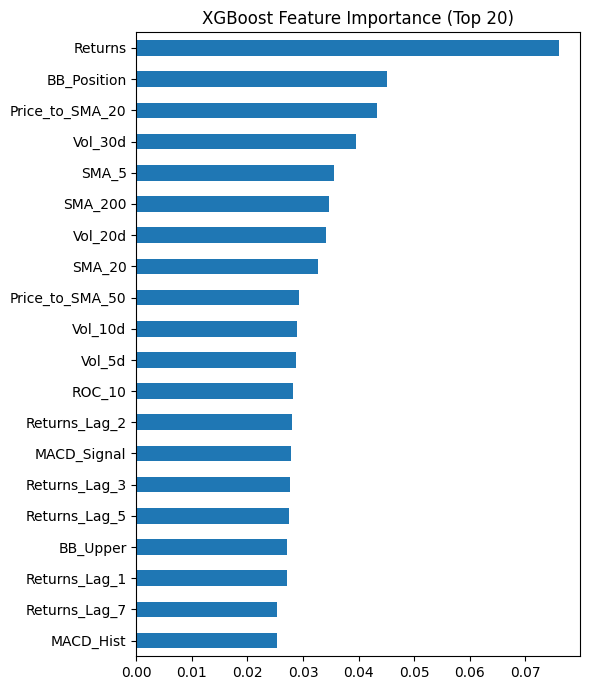

In [5]:
import pandas as pd, numpy as np, json, gc, time, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier


ts0 = time.time()
print(">> Loading CSVs ...")
train = pd.read_csv("/content/train_data.csv")
val   = pd.read_csv("/content/val_data.csv")
test  = pd.read_csv("/content/test_data.csv")
print("train/val/test shapes:", train.shape, val.shape, test.shape)

def drop_zero_rows(df):
    z = (df.fillna(0) == 0).all(axis=1)
    if "Volume" in df.columns:
        z |= (df["Volume"].fillna(0) == 0)
    out = df.loc[~z].copy()
    return out

train = drop_zero_rows(train)
val   = drop_zero_rows(val)
test  = drop_zero_rows(test)
print("after drop_zero_rows:", train.shape, val.shape, test.shape)


def get_label_and_align(df):
    df = df.copy()
    if "Price_Direction" in df.columns:
        y = df["Price_Direction"].astype(int).values
        return df, y
    if "Next_Day_Return" in df.columns:
        y = (df["Next_Day_Return"] > 0).astype(int).values
        return df, y
    if "Close" in df.columns:
        ret_fwd1 = np.log(df["Close"].shift(-1)) - np.log(df["Close"])
        df["_y_tmp"] = (ret_fwd1 > 0).astype(int)
        df = df.dropna(subset=["_y_tmp"]).reset_index(drop=True)
        y = df.pop("_y_tmp").astype(int).values
        return df, y
    raise ValueError("No label column found.")

train, y_tr = get_label_and_align(train)
val,   y_va = get_label_and_align(val)
test,  y_te = get_label_and_align(test)

#Feature
ban_cols = {
    "Date","Coin","Name","Open","High","Low","Close","Volume",
    "High_Low","High_Close_Prev","Low_Close_Prev","True_Range",
    "Next_Day_Return","Tail_Risk_Event","Price_Direction"
}

feat_cols = [c for c in train.columns if c not in ban_cols]
print(f">> Using {len(feat_cols)} features.")
print("Example features:", feat_cols[:10])


X_tr = train[feat_cols].to_numpy(dtype="float32")
X_va = val[feat_cols].to_numpy(dtype="float32")
X_te = test[feat_cols].to_numpy(dtype="float32")

imp = SimpleImputer(strategy="median")
X_tr = imp.fit_transform(X_tr).astype("float32")
X_va = imp.transform(X_va).astype("float32")
X_te = imp.transform(X_te).astype("float32")

gc.collect()

#Evaluation
def eval_split(name, model, X, y, thr=0.5, verbose=True):
    prob = model.predict_proba(X)[:,1]
    pred = (prob >= thr).astype(int)
    out = {
        "split": name,
        "roc_auc": float(roc_auc_score(y, prob)),
        "balanced_acc": float(balanced_accuracy_score(y, pred))
    }
    if verbose:
        print(f"\n=== {name.upper()} ===")
        print(out)
        print(classification_report(y, pred, digits=3))
        print("Confusion matrix:\n", confusion_matrix(y, pred))
    return out, prob, pred


# 1. Fast baseline XGBoost
print("\n>> Training FAST baseline XGB ...")

xgb_fast = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    tree_method="hist"
)

xgb_fast.fit(X_tr, y_tr)

val_metrics_fast, val_prob_fast, val_pred_fast = eval_split("val (FAST)", xgb_fast, X_va, y_va)

# 2. Tiny Grid Search
grid = list(ParameterGrid({
    "max_depth": [3, 4, 5],
    "subsample": [0.7, 0.9]
}))

best_auc, best_model, best_params = -1.0, None, None

for p in grid:
    m = XGBClassifier(
        n_estimators=250,
        max_depth=p["max_depth"],
        subsample=p["subsample"],
        colsample_bytree=0.8,
        learning_rate=0.05,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        tree_method="hist"
    ).fit(X_tr, y_tr)

    prob_va = m.predict_proba(X_va)[:,1]
    auc = roc_auc_score(y_va, prob_va)
    if auc > best_auc:
        best_auc, best_model, best_params = auc, m, p

print("Best VAL AUC (tiny grid):", round(best_auc, 6), best_params)

# 3. Final XGBoost model
print("\n>> Train FINAL XGB with best tiny-grid params ...")

final_xgb = XGBClassifier(
    n_estimators=500,
    max_depth=best_params["max_depth"],
    subsample=best_params["subsample"],
    colsample_bytree=0.8,
    learning_rate=0.03,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    tree_method="hist"
).fit(X_tr, y_tr)

val_metrics, val_prob, val_pred = eval_split("val", final_xgb, X_va, y_va)
test_metrics, test_prob, test_pred = eval_split("test", final_xgb, X_te, y_te)


imp_series = pd.Series(final_xgb.feature_importances_, index=feat_cols).sort_values(ascending=False)

plt.figure(figsize=(6,7))
imp_series.head(20).iloc[::-1].plot(kind="barh")
plt.title("XGBoost Feature Importance (Top 20)")
plt.tight_layout()
plt.savefig("xgb_feature_importance_top20.png", dpi=200)


pd.DataFrame({"y_true": y_va, "prob_up": val_prob, "y_pred": val_pred}).to_csv("xgb_preds_val.csv", index=False)
pd.DataFrame({"y_true": y_te, "prob_up": test_prob, "y_pred": test_pred}).to_csv("xgb_preds_test.csv", index=False)
imp_series.to_csv("xgb_feature_importance.csv")

with open("xgb_metrics.json","w") as f:
    json.dump({
        "val": val_metrics,
        "test": test_metrics,
        "fast_val": val_metrics_fast,
        "params_final": {
            "n_estimators": 500,
            "max_depth": best_params["max_depth"],
            "subsample": best_params["subsample"],
            "colsample_bytree": 0.8,
            "learning_rate": 0.03,
            "random_state": 42
        }
    }, f, indent=2)

print("\nArtifacts saved:",
      "xgb_preds_val.csv, xgb_preds_test.csv, xgb_feature_importance.csv, xgb_feature_importance_top20.png, xgb_metrics.json")
print("Total time: %.1f sec" % (time.time()-ts0))
